### A/B testing 


In [38]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm 
from scipy.stats import chi2_contingency

### Charger les données : 

In [3]:
df = pd.read_csv("ab_data.csv")

In [4]:
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [5]:
#les valeurs manquantes 
df.isnull().sum()


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

il y a aucune valeur manquante 

In [10]:
# vérifier si y a des incohérences : 

incoherence = df.query( "(group == 'control' and landing_page == 'new_page') or\
                        (group == 'treatment' and landing_page == 'old_page')")
print(incoherence)

        user_id                   timestamp      group landing_page  converted
22       767017  2017-01-12 22:58:14.991443    control     new_page          0
240      733976  2017-01-11 15:11:16.407599    control     new_page          0
308      857184  2017-01-20 07:34:59.832626  treatment     old_page          0
327      686623  2017-01-09 14:26:40.734775  treatment     old_page          0
357      856078  2017-01-12 12:29:30.354835  treatment     old_page          0
...         ...                         ...        ...          ...        ...
294014   813406  2017-01-09 06:25:33.223301  treatment     old_page          0
294200   928506  2017-01-13 21:32:10.491309    control     new_page          0
294252   892498  2017-01-22 01:11:10.463211  treatment     old_page          0
294253   886135  2017-01-06 12:49:20.509403    control     new_page          0
294331   689637  2017-01-13 11:34:28.339532    control     new_page          0

[3893 rows x 5 columns]


In [12]:
#Correction des incohérence , on garde que les données correctes 

df_clean = df.query( "(group == 'control' and landing_page == 'old_page') or\
                        (group == 'treatment' and landing_page == 'new_page')")
print(df_clean)

        user_id                   timestamp      group landing_page  converted
0        851104  2017-01-21 22:11:48.556739    control     old_page          0
1        804228  2017-01-12 08:01:45.159739    control     old_page          0
2        661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3        853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4        864975  2017-01-21 01:52:26.210827    control     old_page          1
...         ...                         ...        ...          ...        ...
294473   751197  2017-01-03 22:28:38.630509    control     old_page          0
294474   945152  2017-01-12 00:51:57.078372    control     old_page          0
294475   734608  2017-01-22 11:45:03.439544    control     old_page          0
294476   697314  2017-01-15 01:20:28.957438    control     old_page          0
294477   715931  2017-01-16 12:40:24.467417  treatment     new_page          0

[290585 rows x 5 columns]


In [23]:
#vérification des doublons 
#nombre tatal de lignes
total_lignes = df_clean.shape[0]

#nombre d'ID unique 
id_unique = df_clean["user_id"].nunique()

#nombre de doublons 
doublons = total_lignes - id_unique 

print(doublons)

1


In [24]:
# suppression des doublons 
df_clean = df_clean.drop_duplicates("user_id", keep="first")


In [25]:
### pie chart (repartition des groupes )
counts = df_clean["group"].value_counts()
print(counts)

group
treatment    145310
control      145274
Name: count, dtype: int64


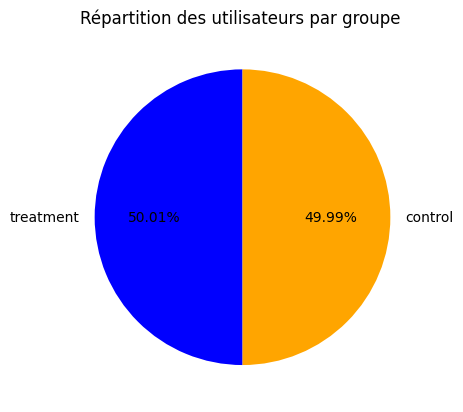

In [26]:
plt.pie(counts, labels = counts.index, #noms des groupes(control, treatment)
        autopct = "%.2f%%", #pour afficher le pourcentage 
        colors = ["blue", "orange"],
       startangle =90)
plt.title("Répartition des utilisateurs par groupe ")
plt.show()

### Taux de conversion : 
Colonne converted = indicateur qui dit si l'utilisateur a realisé l'action attendue apres avoir vu la page. 


In [27]:
# taux de conversion par groupe 
taux_conversion = df_clean.groupby("group")["converted"].mean()
print(taux_conversion)

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64


D'apres les résultats on voit que 12% des utilisateurs du groupe control et 11% du groupe treatment ont réalisé l'action attendue 

### Définition des hypothèses : 
##### H0 : les taux de conversion sont identiques 
##### H1 : les taux de conversion sont différents 

### Test statistique 

#### Z-test pour proportions 

In [37]:
# compter les conversions et effectif : 
conv_control = df_clean.query("group == 'control'")["converted"].sum()
n_control = df_clean.query("group == 'treatment'").shape[0]

conv_treatment = df_clean.query("group == 'treatment'")["converted"].sum()
n_treatment = df_clean.query("group == 'control'").shape[0]

#prpoportions observées 
p_control = conv_control / n_control
p_treatment = conv_treatment / n_treatment 

#proportion combinée sous H0 

p_combined = (conv_control + conv_treatment ) / (n_control + n_treatment )

# Ecart type 
SE = np.sqrt(p_combined *(1 - p_combined) * (1/n_control + 1/n_treatment ))

#stat Z 
z_score = (p_treatment - p_control) / SE

#p_value(bilatérale) 

p_value = 2 * (1 - norm.cdf(abs(z_score)))

print("Z-test pour la proportion : ")
print("Z score :",z_score)
print("p-value :", p_value)

if p_value < 0.05:
    print("difference significative")
else:
    print("non significative")

Z-test pour la proportion : 
Z score : -1.2616957421858055
p-value : 0.2070582896065547
non significative


In [39]:
# Construire la table de contingence
table = pd.crosstab(df_clean["group"], df_clean["converted"])
print("Table de contingence :\n", table)

# Test du Chi²
chi2, p_value, dof, expected = chi2_contingency(table)

print("\nChi² test d'indépendance :")
print(" - Chi² :", chi2)
print(" - ddl :", dof)
print(" - p-value :", p_value)

Table de contingence :
 converted       0      1
group                   
control    127785  17489
treatment  128046  17264

Chi² test d'indépendance :
 - Chi² : 1.7035660051885058
 - ddl : 1
 - p-value : 0.19182228096235662


vu que la p-value qui est largement supérieur à 5% donc on ne rejette pas l'hypothèse H0 car il n ya pas de différence statistique significative entre l'ancienne(control) et la nouvelle version(treatment)

### Différence de conversion entre groupes : 

In [40]:
# Taux de conversion par groupe 
conv_rates = df_clean.groupby("group")["converted"].mean() 
diff = conv_rates["treatment"] - conv_rates["control"] 
print("Différence de conversion (treatment - control) :", diff)
 

Différence de conversion (treatment - control) : -0.0015782389853555567


### Intervalle de confiance à 95 %

n utilise la formule classique pour un IC sur la différence de proportions :
IC=(diff−1.96×SE,  diff+1.96×SE)
IC=(diff−1.96×SE,diff+1.96×SE)

In [45]:
# Variables 
p_c = conv_rates["control"] 
p_t = conv_rates["treatment"]
n_c = df_clean.query("group == 'control'").shape[0] 
n_t = df_clean.query("group == 'treatment'").shape[0]
# Différence 
diff = p_t - p_c 
# Ecart-type de la différence 
SE = np.sqrt(p_c*(1-p_c)/n_c + p_t*(1-p_t)/n_t) 
# Intervalle de confiance 
z = 1.96 
# pour 95% 
ci_lower = diff - z*SE 
ci_upper = diff + z*SE 
print("Différence :", diff) 
print("Intervalle de confiance à 95% :", (ci_lower, ci_upper)) 

Différence : -0.0015782389853555567
Intervalle de confiance à 95% : (-0.003937903604443846, 0.0007814256337327326)


### Barplot comparant les taux de conversion

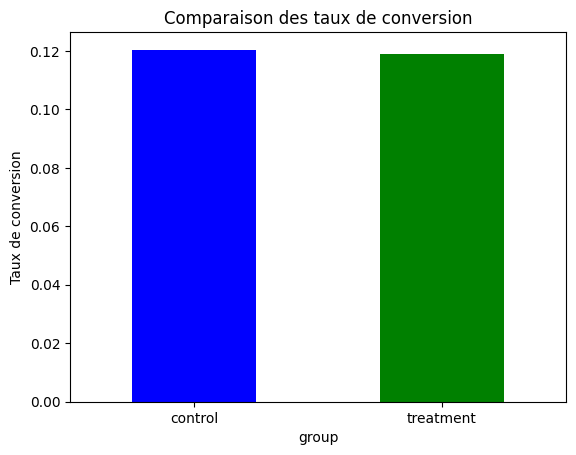

In [50]:
conv_rates.plot(kind="bar", color=["blue", "green"])
plt.ylabel("Taux de conversion") 
plt.title("Comparaison des taux de conversion") 
plt.xticks(rotation=0)
plt.show()